# CNN + 분류 모델 (학습데이터셋: final_training_data_sampled_1500_category_03)

In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

# 데이터 준비 및 전처리
- combined_result.csv (raw_data + 기타소음4)

In [3]:
#학습 데이터 준비
df = pd.read_csv("final_training_data_sampled_1500_category_03.csv", encoding='utf-8')
feature_cols = [f'mfcc_{i}' for i in range(1, 51)]
df = df[feature_cols + ['category_03']]

In [4]:
df.shape

(16500, 51)

In [5]:
df.info

<bound method DataFrame.info of            mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0     -470.270660  156.080307  -6.749740 -16.042160  -3.874907   3.941253   
1     -460.384155  180.129044  11.334196  11.868873  -4.974021   6.809534   
2     -449.925873  171.836411   2.386576  22.721798  -1.736225   6.190225   
3     -455.254059  181.796967   9.294571  10.934427  -4.022550   5.616430   
4     -288.710693  213.676682 -41.471188 -42.155613 -33.182774 -24.146034   
...           ...         ...        ...        ...        ...        ...   
16495 -393.683350  112.838249  78.327019  53.811954  39.379765  30.957418   
16496 -378.663422  134.701477  79.424789  49.431168  34.184185  28.483421   
16497 -461.395416  121.848076  89.299278  62.308353  43.243988  29.191967   
16498 -493.641632  157.938858  25.808128   8.548108  40.262383  37.603741   
16499 -355.461334  135.167755  75.394547  46.334789  31.962107  27.757746   

          mfcc_7     mfcc_8     mfcc_9    m

In [6]:
df['category_03'].value_counts()

고양이       1500
발전기       1500
이륜차경적     1500
차량경적      1500
차량사이렌     1500
개         1500
이륜차주행음    1500
항타기       1500
콘크리트펌프    1500
차량주행음     1500
공구        1500
Name: category_03, dtype: int64

# 모델 생성

In [7]:
# 소음 카테고리 변환 함수
def categorize_noise(category):
    if category in ['이륜차경적']:
        return '이륜차경적'
    elif category in ['이륜차주행음']:
        return '이륜차주행음'
    elif category in ['차량사이렌']:
        return '차량사이렌'
    elif category in ['차량주행음']:
        return '차량주행음'
    elif category in ['차량경적']:
        return '차량경적'
    else:
        return '기타소음'

df['label'] = df['category_03'].apply(categorize_noise)
df = df.drop('category_03', axis=1)

X = df[feature_cols].values  # MFCC 특징 값
y = df['label'].values       # 레이블

# 레이블 인코딩 (문자 → 숫자)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # One-hot 인코딩

# 데이터셋 분할 (훈련:테스트 = 80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y)

# CNN 입력 형태로 변환 (3D 텐서: 샘플 수 x 시간 축 x 특징 수)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [8]:
df['label'].value_counts()

기타소음      9000
이륜차경적     1500
차량경적      1500
차량사이렌     1500
이륜차주행음    1500
차량주행음     1500
Name: label, dtype: int64

## CNN

In [9]:
# CNN 모델 정의
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_categorical.shape[1], activation='softmax')  # 출력층 (카테고리 수만큼 출력)
])

In [10]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# 테스트 정확도 출력
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# 테스트 데이터에 대한 예측 수행
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스 인덱스
y_true_classes = np.argmax(y_test, axis=1)  # 실제 클래스 인덱스

# 정확도 계산
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
class_names = label_encoder.classes_
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Epoch 1/30
413/413 [==============================] - 3s 7ms/step - loss: 0.8414 - accuracy: 0.7455 - val_loss: 0.3060 - val_accuracy: 0.9082
Epoch 2/30
413/413 [==============================] - 3s 7ms/step - loss: 0.3907 - accuracy: 0.8707 - val_loss: 0.2217 - val_accuracy: 0.9339
Epoch 3/30
413/413 [==============================] - 3s 7ms/step - loss: 0.3082 - accuracy: 0.8927 - val_loss: 0.2065 - val_accuracy: 0.9385
Epoch 4/30
413/413 [==============================] - 3s 6ms/step - loss: 0.2632 - accuracy: 0.9092 - val_loss: 0.1547 - val_accuracy: 0.9473
Epoch 5/30
413/413 [==============================] - 3s 6ms/step - loss: 0.2291 - accuracy: 0.9177 - val_loss: 0.1446 - val_accuracy: 0.9552
Epoch 6/30
413/413 [==============================] - 3s 6ms/step - loss: 0.2139 - accuracy: 0.9267 - val_loss: 0.1311 - val_accuracy: 0.9591
Epoch 7/30
413/413 [==============================] - 3s 6ms/step - loss: 0.1910 - accuracy: 0.9318 - val_loss: 0.1314 - val_accuracy: 0.9555
Epoch 

### 모델 저장 - cnn1_6classfication_category_03

In [11]:
# 모델 저장
model.save('cnn1_6classfication_category_03.h5') 
print("모델이 cnn1_6classfication_category_03.h5 파일로 저장되었습니다.")

모델이 cnn1_6classfication_category_03.h5 파일로 저장되었습니다.


In [12]:
from tensorflow import keras
import numpy as np

# 저장된 모델 로드
loaded_model = keras.models.load_model('cnn1_6classfication_category_03.h5')

# 모델 구조 확인
loaded_model.summary()

# 테스트 데이터로 예측 수행
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 정확도 계산
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Loaded Model Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
from sklearn.metrics import classification_report
class_names = label_encoder.classes_
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0

### 성능 개선
- 배치 정규화 (Batch Normalisation) 레이어 Conv1D 와 Dense 추가
- 앙상블 기법 적용
- ReduceROnPlateau 콜백 사용 
- 모델 구조 함수화

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 준비 (기존 코드와 동일)
df = pd.read_csv("combined_result.csv", encoding='utf-8')
feature_cols = [f'mfcc_{i}' for i in range(1, 51)]
df = df[feature_cols + ['category_03']]

def categorize_noise(category):
    if category in ['이륜차경적']:
        return '이륜차경적'
    elif category in ['이륜차주행음']:
        return '이륜차주행음'
    elif category in ['차량사이렌']:
        return '차량사이렌'
    elif category in ['차량주행음']:
        return '차량주행음'
    elif category in ['차량경적']:
        return '차량경적'
    else:
        return '기타소음'

df['label'] = df['category_03'].apply(categorize_noise)
df = df.drop('category_03', axis=1)

X = df[feature_cols].values
y = df['label'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 개선된 CNN 모델 정의
def create_model():
    inputs = Input(shape=(X_train.shape[1], 1))
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(y_categorical.shape[1], activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 앙상블 모델 생성
def create_ensemble(num_models=3):
    models = []
    for _ in range(num_models):
        model = create_model()
        models.append(model)
    return models

# 앙상블 모델 학습
ensemble = create_ensemble()

# 학습률 스케줄링
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# 모델 학습
histories = []
for i, model in enumerate(ensemble):
    print(f"Training model {i+1}/{len(ensemble)}")
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])
    histories.append(history)

# 앙상블 예측
def ensemble_predict(models, X):
    predictions = [model.predict(X) for model in models]
    return np.mean(predictions, axis=0)

# 테스트 데이터에 대한 앙상블 예측
y_pred_ensemble = ensemble_predict(ensemble, X_test)
y_pred_classes = np.argmax(y_pred_ensemble, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 정확도 계산
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Ensemble Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
class_names = label_encoder.classes_
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)


Training model 1/3
Epoch 1/30
451/451 [==============================] - 5s 9ms/step - loss: 0.6574 - accuracy: 0.7635 - val_loss: 0.3456 - val_accuracy: 0.8705
Epoch 2/30
451/451 [==============================] - 4s 9ms/step - loss: 0.4213 - accuracy: 0.8452 - val_loss: 0.2862 - val_accuracy: 0.8932
Epoch 3/30
451/451 [==============================] - 4s 9ms/step - loss: 0.3591 - accuracy: 0.8679 - val_loss: 0.2484 - val_accuracy: 0.9018
Epoch 4/30
451/451 [==============================] - 4s 9ms/step - loss: 0.3188 - accuracy: 0.8846 - val_loss: 0.2217 - val_accuracy: 0.9201
Epoch 5/30
451/451 [==============================] - 4s 10ms/step - loss: 0.2950 - accuracy: 0.8916 - val_loss: 0.2260 - val_accuracy: 0.9223
Epoch 6/30
451/451 [==============================] - 6s 13ms/step - loss: 0.2737 - accuracy: 0.8981 - val_loss: 0.1890 - val_accuracy: 0.9287
Epoch 7/30
451/451 [==============================] - 6s 13ms/step - loss: 0.2703 - accuracy: 0.9008 - val_loss: 0.1977 - val_a

In [14]:
# 모델 저장
model.save('cnn2_6classfication_category_03.h5')
print("모델이 cnn2_6classfication_category_03.h5 파일로 저장되었습니다.")

모델이 cnn2_6classfication_category_03.h5 파일로 저장되었습니다.


In [15]:
from tensorflow import keras
import numpy as np

# 저장된 모델 로드
loaded_model = keras.models.load_model('cnn2_6classfication_category_03.h5')

# 모델 구조 확인
loaded_model.summary()

# 테스트 데이터로 예측 수행
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 정확도 계산
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Loaded Model Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
from sklearn.metrics import classification_report
class_names = label_encoder.classes_
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 48, 64)            256       
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 64)            256       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 22, 128)           24704     
_________________________________________________________________
batch_normalization_7 (Batch (None, 22, 128)           512 

### 차량 주행음 개선

In [16]:
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(np.argmax(y_train, axis=1)),
                                                 y=np.argmax(y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# 모델 컴파일 및 학습
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[reduce_lr])


Epoch 1/30
451/451 [==============================] - 5s 10ms/step - loss: 0.1708 - accuracy: 0.9373 - val_loss: 0.1589 - val_accuracy: 0.9431
Epoch 2/30
451/451 [==============================] - 5s 10ms/step - loss: 0.1698 - accuracy: 0.9366 - val_loss: 0.1829 - val_accuracy: 0.9337
Epoch 3/30
451/451 [==============================] - 4s 9ms/step - loss: 0.1639 - accuracy: 0.9399 - val_loss: 0.2034 - val_accuracy: 0.9251
Epoch 4/30
451/451 [==============================] - 4s 9ms/step - loss: 0.1550 - accuracy: 0.9392 - val_loss: 0.1602 - val_accuracy: 0.9395
Epoch 5/30
451/451 [==============================] - 5s 10ms/step - loss: 0.1606 - accuracy: 0.9402 - val_loss: 0.1718 - val_accuracy: 0.9359
Epoch 6/30
451/451 [==============================] - 5s 10ms/step - loss: 0.1525 - accuracy: 0.9397 - val_loss: 0.1475 - val_accuracy: 0.9534
Epoch 7/30
451/451 [==============================] - 4s 9ms/step - loss: 0.1543 - accuracy: 0.9395 - val_loss: 0.1786 - val_accuracy: 0.9315
Ep

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight

# 데이터 준비 (기존 코드와 동일)
df = pd.read_csv("combined_result.csv", encoding='utf-8')
feature_cols = [f'mfcc_{i}' for i in range(1, 51)]
df = df[feature_cols + ['category_03']]

def categorize_noise(category):
    if category in ['이륜차경적']:
        return '이륜차경적'
    elif category in ['이륜차주행음']:
        return '이륜차주행음'
    elif category in ['차량사이렌']:
        return '차량사이렌'
    elif category in ['차량주행음']:
        return '차량주행음'
    elif category in ['차량경적']:
        return '차량경적'
    else:
        return '기타소음'

df['label'] = df['category_03'].apply(categorize_noise)
df = df.drop('category_03', axis=1)

X = df[feature_cols].values
y = df['label'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(np.argmax(y_train, axis=1)),
                                                 y=np.argmax(y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# 개선된 CNN 모델 정의
def create_model():
    inputs = Input(shape=(X_train.shape[1], 1))
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(y_categorical.shape[1], activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 앙상블 모델 생성
def create_ensemble(num_models=3):
    models = []
    for _ in range(num_models):
        model = create_model()
        models.append(model)
    return models

# 앙상블 모델 학습
ensemble = create_ensemble()

# 학습률 스케줄링
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# 모델 학습
histories = []
for i, model in enumerate(ensemble):
    print(f"Training model {i+1}/{len(ensemble)}")
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), 
                        class_weight=class_weight_dict, callbacks=[reduce_lr])
    histories.append(history)

# 앙상블 예측
def ensemble_predict(models, X):
    predictions = [model.predict(X) for model in models]
    return np.mean(predictions, axis=0)

# 테스트 데이터에 대한 앙상블 예측
y_pred_ensemble = ensemble_predict(ensemble, X_test)
y_pred_classes = np.argmax(y_pred_ensemble, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 정확도 계산
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Ensemble Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
class_names = label_encoder.classes_
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)


Training model 1/3
Epoch 1/30
451/451 [==============================] - 5s 9ms/step - loss: 0.6919 - accuracy: 0.7610 - val_loss: 0.3852 - val_accuracy: 0.8519
Epoch 2/30
451/451 [==============================] - 4s 9ms/step - loss: 0.4618 - accuracy: 0.8320 - val_loss: 0.2790 - val_accuracy: 0.9015
Epoch 3/30
451/451 [==============================] - 4s 9ms/step - loss: 0.3836 - accuracy: 0.8620 - val_loss: 0.2397 - val_accuracy: 0.9140
Epoch 4/30
451/451 [==============================] - 4s 9ms/step - loss: 0.3442 - accuracy: 0.8751 - val_loss: 0.2540 - val_accuracy: 0.9032
Epoch 5/30
451/451 [==============================] - 4s 9ms/step - loss: 0.3140 - accuracy: 0.8867 - val_loss: 0.2248 - val_accuracy: 0.9154
Epoch 6/30
451/451 [==============================] - 4s 9ms/step - loss: 0.2880 - accuracy: 0.8969 - val_loss: 0.2289 - val_accuracy: 0.9121
Epoch 7/30
451/451 [==============================] - 4s 9ms/step - loss: 0.2869 - accuracy: 0.8978 - val_loss: 0.2573 - val_accu

In [19]:
# # 모델 저장
# model.save('updated2_cnn_model_6classfication.h5')
# print("모델이 updated2_cnn_model_6classfication.h5 파일로 저장되었습니다.")

### 차량주행음 - Precision 과 f1-score 개선
- 오버샘플링

In [18]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 준비
df = pd.read_csv("combined_result.csv", encoding='utf-8')
feature_cols = [f'mfcc_{i}' for i in range(1, 51)]
df = df[feature_cols + ['category_03']]

def categorize_noise(category):
    if category in ['이륜차경적']:
        return '이륜차경적'
    elif category in ['이륜차주행음']:
        return '이륜차주행음'
    elif category in ['차량사이렌']:
        return '차량사이렌'
    elif category in ['차량주행음']:
        return '차량주행음'
    elif category in ['차량경적']:
        return '차량경적'
    else:
        return '기타소음'

df['label'] = df['category_03'].apply(categorize_noise)
df = df.drop('category_03', axis=1)

X = df[feature_cols].values
y = df['label'].values

# 레이블 인코딩 및 데이터 분할
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

# 오버샘플링 적용 (훈련 데이터만)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 원-핫 인코딩
y_train_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test)

# 데이터 형태 변환
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# CNN 모델 정의
def create_model():
    inputs = Input(shape=(X_train_resampled.shape[1], 1))
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(y_test_categorical.shape[1], activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 앙상블 모델 생성
def create_ensemble(num_models=3):
    models = []
    for _ in range(num_models):
        model = create_model()
        models.append(model)
    return models

# 앙상블 모델 학습
ensemble = create_ensemble()

# 학습률 스케줄링 콜백 정의
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# 모델 학습 (오버샘플링된 데이터 사용)
histories = []
for i, model in enumerate(ensemble):
    print(f"Training model {i+1}/{len(ensemble)}")
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_resampled, y_train_categorical,
                        epochs=30,
                        batch_size=32,
                        validation_data=(X_test, y_test_categorical),
                        callbacks=[reduce_lr])
    histories.append(history)

# 앙상블 예측 함수 정의
def ensemble_predict(models, X):
    predictions = [model.predict(X) for model in models]
    return np.mean(predictions, axis=0)

# 테스트 데이터에 대한 앙상블 예측 수행
y_pred_ensemble = ensemble_predict(ensemble, X_test)

# 클래스별로 가장 높은 확률을 가진


Training model 1/3
Epoch 1/30
711/711 [==============================] - 7s 9ms/step - loss: 0.6045 - accuracy: 0.7782 - val_loss: 0.3691 - val_accuracy: 0.8696
Epoch 2/30
711/711 [==============================] - 6s 8ms/step - loss: 0.3752 - accuracy: 0.8652 - val_loss: 0.2540 - val_accuracy: 0.9071
Epoch 3/30
711/711 [==============================] - 6s 8ms/step - loss: 0.3187 - accuracy: 0.8835 - val_loss: 0.2551 - val_accuracy: 0.9037
Epoch 4/30
711/711 [==============================] - 6s 8ms/step - loss: 0.2666 - accuracy: 0.9068 - val_loss: 0.2031 - val_accuracy: 0.9215
Epoch 5/30
711/711 [==============================] - 6s 8ms/step - loss: 0.2505 - accuracy: 0.9109 - val_loss: 0.2044 - val_accuracy: 0.9218
Epoch 6/30
711/711 [==============================] - 6s 8ms/step - loss: 0.2291 - accuracy: 0.9186 - val_loss: 0.1806 - val_accuracy: 0.9334
Epoch 7/30
711/711 [==============================] - 6s 8ms/step - loss: 0.2204 - accuracy: 0.9220 - val_loss: 0.1836 - val_accu

In [19]:
# 클래스별로 가장 높은 확률을 가진 클래스 인덱스를 선택
y_pred_classes = np.argmax(y_pred_ensemble, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# 정확도 계산 및 출력
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Ensemble Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
class_names = label_encoder.classes_
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Ensemble Accuracy: 0.9495
Classification Report:
               precision    recall  f1-score   support

        기타소음       0.96      0.97      0.96       373
       이륜차경적       0.98      0.95      0.97       912
      이륜차주행음       0.96      0.93      0.95       947
        차량경적       0.93      0.95      0.94       638
       차량사이렌       0.98      0.96      0.97       398
       차량주행음       0.83      0.96      0.89       337

    accuracy                           0.95      3605
   macro avg       0.94      0.95      0.95      3605
weighted avg       0.95      0.95      0.95      3605

Confusion Matrix:
 [[360   1   7   0   3   2]
 [  1 868   2  41   0   0]
 [ 10   0 879   0   2  56]
 [  2  14  11 609   1   1]
 [  2   0   3   3 383   7]
 [  1   0  10   0   2 324]]


# 새로운 wav 파일 분류 함수

In [22]:
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 48, 64)            256       
_________________________________________________________________
batch_normalization_9 (Batch (None, 48, 64)            256       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 64)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 22, 128)           24704     
_________________________________________________________________
batch_normalization_10 (Batc (None, 22, 128)           512 

In [24]:
def classify_audio(audio_path):
    try:
        # 음원 파일 로드
        y, sr = librosa.load(audio_path, sr=44100)

        # MFCC 특징 추출
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)

        # 추출된 MFCC 특징의 평균값을 사용 (각 MFCC 차수별로 하나의 값)
        mfccs_processed = np.mean(mfccs, axis=1)

        # CNN 입력 형태로 변환 (3D 텐서)
        new_data = mfccs_processed.reshape(1, -1, 1)

        # 예측 수행
        predicted_label_encoded = np.argmax(model.predict(new_data), axis=-1)[0]
        predicted_label = label_encoder.inverse_transform([predicted_label_encoded])[0]

        return predicted_label

    except Exception as e:
        print(f"Error processing audio file: {e}")
        return "Unknown"


## 테스트 데이터셋 평가

In [39]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. LabelEncoder 초기화 (학습 데이터 기반)
label_encoder = LabelEncoder()
df_train = pd.read_csv("final_training_data_sampled_1500_category_03.csv", encoding='utf-8')
# categorize_noise 함수를 적용하여 레이블을 변환
df_train['label'] = df_train['category_03'].apply(lambda x: categorize_noise(x))
label_encoder.fit(df_train['label'])

# 2. 모델 로드
loaded_model = load_model('cnn1_6classfication_category_03.h5')
loaded_model.summary()

# 3. 테스트 데이터 로드
test_data_path = 'final_test_sampled_90_category_03.csv'
df_test = pd.read_csv(test_data_path, encoding='utf-8')

# 4. 테스트 데이터 전처리
feature_cols = [f'mfcc_{i}' for i in range(1, 51)]
X_test = df_test[feature_cols].values
y_true_original = df_test['category_03'].values

# 5. 레이블 변환 및 인코딩
def categorize_noise(category):
    if category in ['이륜차경적']:
        return '이륜차경적'
    elif category in ['이륜차주행음']:
        return '이륜차주행음'
    elif category in ['차량사이렌']:
        return '차량사이렌'
    elif category in ['차량주행음']:
        return '차량주행음'
    elif category in ['차량경적']:
        return '차량경적'
    else:
        return '기타소음'

# 테스트 데이터의 레이블을 categorize_noise 함수를 사용하여 변환
y_true = df_test['category_03'].apply(categorize_noise).values
# 학습 데이터셋으로 학습된 LabelEncoder를 사용하여 테스트 데이터 레이블을 인코딩
y_true_encoded = label_encoder.transform(y_true)


# CNN 입력 형태로 변환
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 6. 예측 수행
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 7. 평가
accuracy = accuracy_score(y_true_encoded, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

class_names = label_encoder.classes_
report = classification_report(y_true_encoded, y_pred_classes, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

conf_matrix = confusion_matrix(y_true_encoded, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0

Train unique labels: ['기타소음' '이륜차경적' '이륜차주행음' '차량경적' '차량사이렌' '차량주행음']
Test unique labels: ['기타소음' '이륜차경적' '이륜차주행음' '차량경적' '차량사이렌' '차량주행음']
X_train shape: (9000, 50, 1)
X_test shape: (1320, 50, 1)
Augmented X_train shape: (15000, 50, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 25, 64)       512         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 25, 64)       256         conv1d[0][0]                     
________________________________________________________

/home/lab05/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


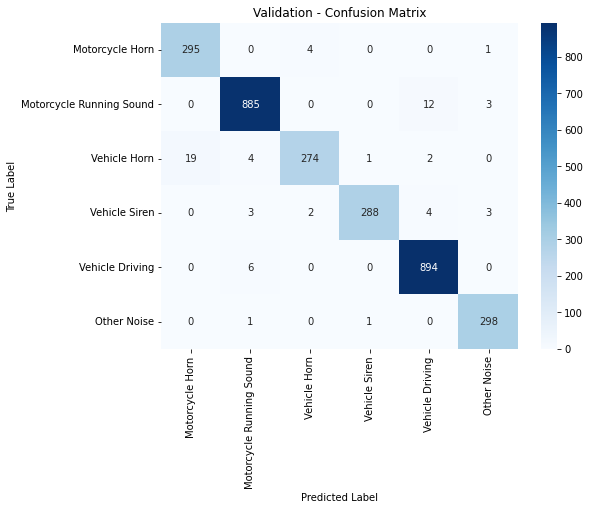

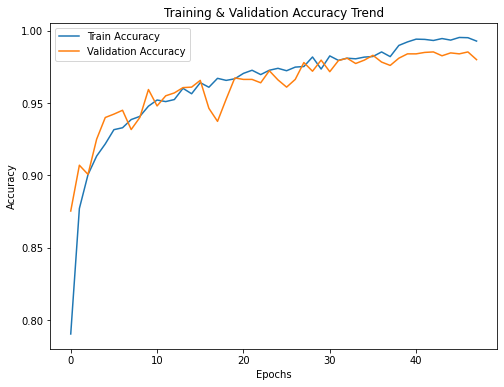


Validation Evaluation:
 Accuracy: 0.9780

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.94      0.98      0.96       300
Motorcycle Running Sound       0.98      0.98      0.98       900
            Vehicle Horn       0.98      0.91      0.94       300
           Vehicle Siren       0.99      0.96      0.98       300
         Vehicle Driving       0.98      0.99      0.99       900
             Other Noise       0.98      0.99      0.99       300

                accuracy                           0.98      3000
               macro avg       0.98      0.97      0.97      3000
            weighted avg       0.98      0.98      0.98      3000



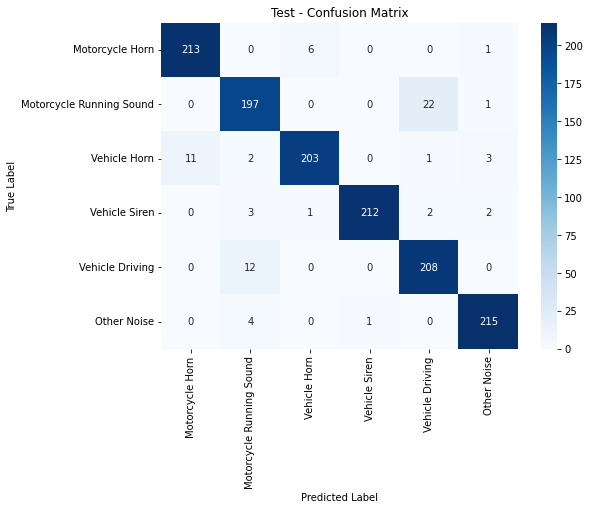

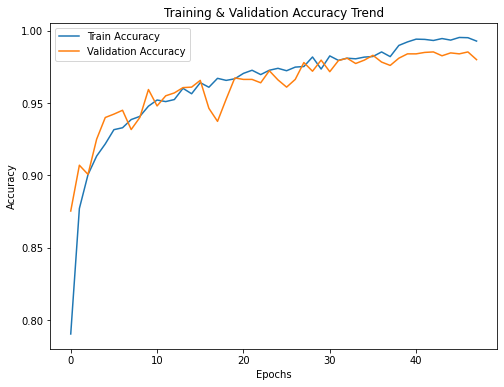


Test Evaluation:
 Accuracy: 0.9455

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.95      0.97      0.96       220
Motorcycle Running Sound       0.90      0.90      0.90       220
            Vehicle Horn       0.97      0.92      0.94       220
           Vehicle Siren       1.00      0.96      0.98       220
         Vehicle Driving       0.89      0.95      0.92       220
             Other Noise       0.97      0.98      0.97       220

                accuracy                           0.95      1320
               macro avg       0.95      0.95      0.95      1320
            weighted avg       0.95      0.95      0.95      1320



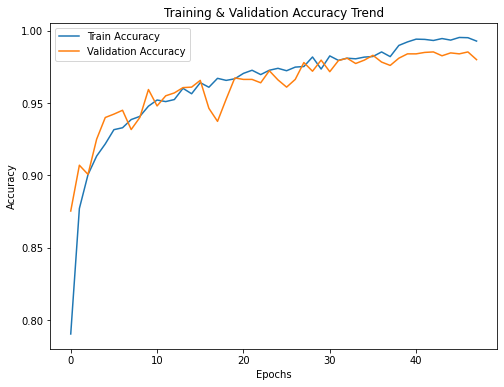


--- Sample Predictions ---
Sample 0: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
Sample 1: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
Sample 2: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
Sample 3: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
Sample 4: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
Sample 5: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
Sample 6: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
Sample 7: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
Sample 8: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
Sample 9: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import class_weight

#############################################
# Part 0. 데이터 로드 및 전처리
#############################################
train_file = "final_training_data_sampled_1500_ood_label.csv"  # 학습 데이터셋
test_file  = "final_test_data_sampled_220_ood_label.csv"   # 테스트 데이터셋

train_df = pd.read_csv(train_file)
test_df  = pd.read_csv(test_file)

#############################################
# Part 1. 라벨 매핑 및 인코딩
#############################################
# 최종 6개 라벨 :
# 교통 소음 5개: '이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음'
# 기타소음: '기타소음'
final_labels = ['이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음', '기타소음']
# 영어 라벨
english_labels = ['Motorcycle Horn', 'Motorcycle Running Sound', 'Vehicle Horn', 'Vehicle Siren', 'Vehicle Driving', 'Other Noise']

label_to_code = {label: i for i, label in enumerate(final_labels)}
unknown_label_index = label_to_code['기타소음']

if 'ood_label' in train_df.columns:
    train_df['encoded_label'] = train_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("학습 데이터에 'ood_label' 컬럼이 없습니다.")

if 'ood_label' in test_df.columns:
    test_df['encoded_label'] = test_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("테스트 데이터에 'ood_label' 컬럼이 없습니다.")

print("Train unique labels:", np.unique(train_df['ood_label']))
print("Test unique labels:", np.unique(test_df['ood_label']))

y_train = train_df['encoded_label'].values
y_test  = test_df['encoded_label'].values

#############################################
# Part 2. 입력 데이터 준비 (MFCC)
#############################################
mfcc_columns = [f"mfcc_{i}" for i in range(1, 51)]
X_train = train_df[mfcc_columns].values
X_test = test_df[mfcc_columns].values

# Reshape: (samples, 50) -> (samples, 50, 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

#############################################
# Part 3. 데이터 증강: 오토바이 주행음(1)과 차량 주행음(4)
#############################################
def augment_mfcc(mfcc, noise_level=0.02):
    # 간단하게 노이즈를 추가하는 증강 함수 (여기에 추가 증강 기법을 같이 적용 가능)
    noise = np.random.normal(0, noise_level, mfcc.shape)
    return mfcc + noise

X_train_aug = []
y_train_aug = []

for i in range(len(X_train)):
    sample = X_train[i]
    lbl = y_train[i]
    # 원본 데이터 추가
    X_train_aug.append(sample)
    y_train_aug.append(lbl)
    # 만약 오토바이 주행음(1) 또는 차량 주행음(4) 클래스면 추가 증강 2회 진행
    if lbl in [1, 4]:
        for _ in range(2):
            aug_sample = augment_mfcc(sample, noise_level=0.02)
            X_train_aug.append(aug_sample)
            y_train_aug.append(lbl)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)
print("Augmented X_train shape:", X_train_aug.shape)

#############################################
# Part 4. Train/Validation Split & One-hot Encoding
#############################################
y_train_cat = to_categorical(y_train_aug, num_classes=len(final_labels))
y_test_cat = to_categorical(y_test, num_classes=len(final_labels))

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_aug, y_train_cat, test_size=0.20, random_state=42, stratify=y_train_aug
)

#############################################
# Part 5. 모델 정의: 수정된 ResNet 모델 (출력 유닛 6개)
#############################################
def residual_block(x, filters, kernel_size=3, stride=1, use_dropout=False):
    shortcut = x
    x = Conv1D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    if use_dropout:
        x = Dropout(0.2)(x)
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, strides=2, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    x = residual_block(x, 64, use_dropout=True)
    x = residual_block(x, 128, stride=2, use_dropout=True)
    x = residual_block(x, 256, stride=2, use_dropout=True)
    x = residual_block(x, 512, stride=2, use_dropout=True)
    x = GlobalAveragePooling1D()(x)
    # 추가 Dense layer로 미세 조정 (차량 주행음 등 구분력 개선)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

num_classes = len(final_labels)   # 6
resnet_model_modified = build_resnet((50, 1), num_classes)
optimizer = Adam(learning_rate=0.001)
resnet_model_modified.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model_modified.summary()

#############################################
# Part 6. 클래스 가중치 재계산 (특히 클래스 1, 4의 가중치를 높임)
#############################################
cw = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_train_split, axis=1)),
                                         y=np.argmax(y_train_split, axis=1))
cw_dict = dict(enumerate(cw))
# 예를 들어, 오토바이 주행음(1)과 차량 주행음(4)가 부족하다면 가중치를 1.5배로 조정
cw_dict[1] *= 1.5
cw_dict[4] *= 1.5
print("클래스 가중치:", cw_dict)

#############################################
# Part 7. 모델 학습
#############################################
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

history = resnet_model_modified.fit(
    X_train_split, y_train_split,
    epochs=150, batch_size=32,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr],
    class_weight=cw_dict,
    verbose=1
)

# 모델 저장 (새 파일명으로 저장)
resnet_model_modified.save("resnet_model_modified_v4.h5")
print("모델이 resnet_model_modified_v4.h5 파일로 저장되었습니다.")

#############################################
# Part 8. 평가 함수 정의 및 적용 (영어 라벨 표시, 정확도 추세 그래프 단 한 번 출력)
#############################################
def evaluate_and_plot(model, X, y_true, dataset_name="Dataset", hist=None):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)

    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=english_labels, yticklabels=english_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    if hist is not None:
        plt.figure(figsize=(8,6))
        plt.plot(hist.history['accuracy'], label='Train Accuracy')
        plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training & Validation Accuracy Trend")
        plt.legend()
        plt.show()

    print(f"\n{dataset_name} Evaluation:")
    print(f" Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=english_labels, zero_division=0))  # zero_division=0 추가
    return acc

# 평가: 검증 데이터 평가
val_acc = evaluate_and_plot(resnet_model_modified, X_val_split, y_val_split, dataset_name="Validation", hist=history)

# 평가: 테스트 데이터 평가
test_acc = evaluate_and_plot(resnet_model_modified, X_test, y_test_cat, dataset_name="Test", hist=history)

#############################################
# Part 9. 정확도 추세 그래프 (Train vs Validation; 단 한 번 출력)
#############################################
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Trend")
plt.legend()
plt.show()

#############################################
# Part 10. 일부 샘플 예측 결과 출력
#############################################
print("\n--- Sample Predictions ---")
index_to_label = {v: k for k, v in label_to_code.items()}
for i in range(10):
    true_lbl = index_to_label[y_test[i]]
    pred_lbl = index_to_label[np.argmax(resnet_model_modified.predict(X_test[i:i+1]))]
    conf = np.max(resnet_model_modified.predict(X_test[i:i+1]))
    print(f"Sample {i}: True = {true_lbl}, Predicted = {pred_lbl}, Confidence = {conf:.4f}")


## 기타소음

### 고양이

In [25]:
folder_path = "/home/ubuntu/data/etc_noise_data_test_final/동물/15.고양이"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_cat = pd.DataFrame(results)

100%|██████████| 274/274 [00:46<00:00,  5.94it/s]


In [26]:
results_df_cat['Predicted Label'].value_counts()

기타소음      271
이륜차주행음      1
차량주행음       1
차량사이렌       1
Name: Predicted Label, dtype: int64

In [27]:
# '기타소음'의 개수와 비율 계산
total_files_cat = len(results_df_cat)  # 전체 파일 개수
etc_noise_count_cat = results_df_cat[results_df_cat['Predicted Label'] == '기타소음'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_cat = (etc_noise_count_cat / total_files_cat) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_cat}")
print(f"'기타소음' Count: {etc_noise_count_cat}")
print(f"'기타소음' Ratio: {etc_noise_ratio_cat:.2f}%")

Total Files: 274
'기타소음' Count: 271
'기타소음' Ratio: 98.91%


In [28]:
# #CSV로 저장
# results_df_cat.to_csv("cat.csv", index=False)
# print("Classification completed. Results saved to 'cat.csv'")

### 강아지

In [29]:
folder_path = "/home/ubuntu/data/etc_noise_data_test_final/동물/14.개"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_dog = pd.DataFrame(results)

100%|██████████| 217/217 [00:54<00:00,  3.95it/s]


In [30]:
results_df_dog['Predicted Label'].value_counts()

기타소음      210
차량사이렌       4
이륜차주행음      2
차량주행음       1
Name: Predicted Label, dtype: int64

In [31]:
# '기타소음'의 개수와 비율 계산
total_files_dog = len(results_df_dog)  # 전체 파일 개수
etc_noise_count_dog = results_df_dog[results_df_dog['Predicted Label'] == '기타소음'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_dog = (etc_noise_count_dog / total_files_dog) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_dog}")
print(f"'기타소음' Count: {etc_noise_count_dog}")
print(f"'기타소음' Ratio: {etc_noise_ratio_dog:.2f}%")

Total Files: 217
'기타소음' Count: 210
'기타소음' Ratio: 96.77%


In [32]:
# # CSV로 저장
# results_df_dog.to_csv("dog.csv", index=False)
# print("Classification completed. Results saved to 'dog.csv'")

### 항타기

In [33]:
folder_path = "/home/ubuntu/data/etc_noise_data_test_final/공사장/18.항타기"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_piledriver = pd.DataFrame(results)

100%|██████████| 133/133 [00:59<00:00,  2.23it/s]


In [34]:
results_df_piledriver['Predicted Label'].value_counts()

기타소음      126
이륜차주행음      5
차량경적        2
Name: Predicted Label, dtype: int64

In [35]:
# '기타소음'의 개수와 비율 계산
total_files_piledriver = len(results_df_piledriver)  # 전체 파일 개수
etc_noise_count_piledriver = results_df_piledriver[results_df_piledriver['Predicted Label'] == '기타소음'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_piledriver = (etc_noise_count_piledriver / total_files_piledriver) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_piledriver}")
print(f"'기타소음' Count: {etc_noise_count_piledriver}")
print(f"'기타소음' Ratio: {etc_noise_ratio_piledriver:.2f}%")

Total Files: 133
'기타소음' Count: 126
'기타소음' Ratio: 94.74%


In [36]:
# # 결과를 CSV로 저장
# results_df_piledriver.to_csv("piledriver.csv", index=False)
# print("Classification completed. Results saved to 'piledriver.csv'")

### 콘크리트펌프

In [37]:
folder_path = "/home/ubuntu/data/etc_noise_data_test_final/공사장/20.콘크리트펌프"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_concrete = pd.DataFrame(results)

100%|██████████| 93/93 [02:04<00:00,  1.33s/it]


In [38]:
results_df_concrete['Predicted Label'].value_counts()

기타소음      88
이륜차주행음     4
차량사이렌      1
Name: Predicted Label, dtype: int64

In [39]:
results_df_concrete['Predicted Label'].value_counts()

# '기타소음'의 개수와 비율 계산
total_files_concrete = len(results_df_concrete)  # 전체 파일 개수
etc_noise_count_concrete = results_df_concrete[results_df_concrete['Predicted Label'] == '기타소음'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_concrete = (etc_noise_count_concrete / total_files_concrete) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_concrete}")
print(f"'기타소음' Count: {etc_noise_count_concrete}")
print(f"'기타소음' Ratio: {etc_noise_ratio_concrete:.2f}%")

Total Files: 93
'기타소음' Count: 88
'기타소음' Ratio: 94.62%


In [40]:
# # CSV로 저장
# results_df_vacuum.to_csv("concrete.csv", index=False)
# print("Classification completed. Results saved to 'concrete.csv'")

### 발전기

In [41]:
folder_path = "/home/ubuntu/data/etc_noise_data_test_final/공사장/20.콘크리트펌프"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_generator = pd.DataFrame(results)

100%|██████████| 93/93 [01:59<00:00,  1.28s/it]


In [42]:
results_df_generator['Predicted Label'].value_counts()

기타소음      88
이륜차주행음     4
차량사이렌      1
Name: Predicted Label, dtype: int64

In [43]:
# '기타소음'의 개수와 비율 계산
total_files_generator = len(results_df_generator)  # 전체 파일 개수
etc_noise_count_generator = results_df_generator[results_df_generator['Predicted Label'] == '기타소음'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_generator = (etc_noise_count_generator / total_files_generator) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_generator}")
print(f"'기타소음' Count: {etc_noise_count_generator}")
print(f"'기타소음' Ratio: {etc_noise_ratio_generator:.2f}%")

Total Files: 93
'기타소음' Count: 88
'기타소음' Ratio: 94.62%


In [44]:
# # CSV로 저장
# results_df_vacuum.to_csv("generator.csv", index=False)
# print("Classification completed. Results saved to 'generator.csv'")

### 공구

In [45]:
folder_path = "/home/ubuntu/data/etc_noise_data_test_final/공구"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_tools = pd.DataFrame(results)

100%|██████████| 172/172 [01:05<00:00,  2.61it/s]


In [46]:
results_df_tools['Predicted Label'].value_counts()

기타소음      146
이륜차주행음     19
차량사이렌       4
차량주행음       2
이륜차경적       1
Name: Predicted Label, dtype: int64

In [47]:
# '기타소음'의 개수와 비율 계산
total_files_tools = len(results_df_tools)  # 전체 파일 개수
etc_noise_count_tools = results_df_tools[results_df_tools['Predicted Label'] == '기타소음'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_tools = (etc_noise_count_tools / total_files_tools) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_tools}")
print(f"'기타소음' Count: {etc_noise_count_tools}")
print(f"'기타소음' Ratio: {etc_noise_ratio_tools:.2f}%")

Total Files: 172
'기타소음' Count: 146
'기타소음' Ratio: 84.88%


In [48]:
# # CSV로 저장
# results_df_vacuum.to_csv("tools.csv", index=False)
# print("Classification completed. Results saved to 'tools.csv'")

## 교통소음

### 차량 사이렌

In [49]:
folder_path = "/home/ubuntu/data/etc_noise_data_test_final/교통소음/2.차량사이렌"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_car_siren = pd.DataFrame(results)

100%|██████████| 249/249 [01:21<00:00,  3.05it/s]


In [50]:
results_df_car_siren['Predicted Label'].value_counts()

차량사이렌     243
차량주행음       3
이륜차주행음      2
차량경적        1
Name: Predicted Label, dtype: int64

In [51]:
# '기타소음'의 개수와 비율 계산
total_files_car_siren = len(results_df_car_siren)  # 전체 파일 개수
etc_noise_count_car_siren = results_df_car_siren[results_df_car_siren['Predicted Label'] == '차량사이렌'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_car_siren = (etc_noise_count_car_siren / total_files_car_siren) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_car_siren}")
print(f"'차량사이렌' Count: {etc_noise_count_car_siren}")
print(f"'차량사이렌' Ratio: {etc_noise_ratio_car_siren:.2f}%")

Total Files: 249
'차량사이렌' Count: 243
'차량사이렌' Ratio: 97.59%


In [52]:
# #CSV로 저장
# results_df_car_siren.to_csv("car_siren.csv", index=False)
# print("Classification completed. Results saved to 'car_siren.csv'")

### 차량 경적

In [53]:
folder_path = "/home/ubuntu/data/raw_data/1.Car/1.horn_of_car"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 5. 결과를 DataFrame으로 변환
results_df_car_horn = pd.DataFrame(results)

100%|██████████| 3189/3189 [15:10<00:00,  3.50it/s]


In [54]:
results_df_car_horn['Predicted Label'].value_counts()

차량경적      3107
이륜차주행음      26
이륜차경적       25
차량주행음       19
차량사이렌        6
기타소음         6
Name: Predicted Label, dtype: int64

In [55]:
# '기타소음'의 개수와 비율 계산
total_files_car_horn = len(results_df_car_horn)  # 전체 파일 개수
etc_noise_count_car_horn = results_df_car_horn[results_df_car_horn['Predicted Label'] == '차량경적'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_car_horn = (etc_noise_count_car_horn / total_files_car_horn) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_car_horn}")
print(f"'차량경적' Count: {etc_noise_count_car_horn}")
print(f"'차량경적' Ratio: {etc_noise_ratio_car_horn:.2f}%")

Total Files: 3189
'차량경적' Count: 3107
'차량경적' Ratio: 97.43%


In [56]:
# # CSV로 저장
# results_df_car_horn.to_csv("car_horn.csv", index=False)
# print("Classification completed. Results saved to 'car_horn.csv'")

### 차량 주행음

In [57]:
folder_path = "/home/ubuntu/data/etc_noise_data_test_final/교통소음/3.차량주행음"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_car_driving = pd.DataFrame(results)

100%|██████████| 227/227 [01:42<00:00,  2.21it/s]


In [58]:
results_df_car_driving['Predicted Label'].value_counts()

차량주행음     215
이륜차주행음      7
기타소음        4
차량경적        1
Name: Predicted Label, dtype: int64

In [59]:
# '기타소음'의 개수와 비율 계산
total_files_car_driving = len(results_df_car_driving)  # 전체 파일 개수
etc_noise_count_car_driving = results_df_car_driving[results_df_car_driving['Predicted Label'] == '차량주행음'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_car_driving = (etc_noise_count_car_driving / total_files_car_driving) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_car_driving}")
print(f"'차량주행음' Count: {etc_noise_count_car_driving}")
print(f"'차량주행음' Ratio: {etc_noise_ratio_car_driving:.2f}%")

Total Files: 227
'차량주행음' Count: 215
'차량주행음' Ratio: 94.71%


In [60]:
# # CSV로 저장
# results_df_car_driving.to_csv("car_driving.csv", index=False)
# print("Classification completed. Results saved to 'car_driving.csv'")

### 이륜차 경적

In [61]:
folder_path = "/home/ubuntu/data/test_data/raw_data_test/2.Motorcycle/4.horn_of_motorcycle"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_motorcycle_horn = pd.DataFrame(results)

100%|██████████| 519/519 [02:05<00:00,  4.14it/s]


In [62]:
results_df_motorcycle_horn['Predicted Label'].value_counts()

이륜차경적     489
차량경적       24
이륜차주행음      4
차량주행음       1
기타소음        1
Name: Predicted Label, dtype: int64

In [63]:
# '기타소음'의 개수와 비율 계산
total_files_motorcycle_horn = len(results_df_motorcycle_horn)  # 전체 파일 개수
etc_noise_count_motorcycle_horn = results_df_motorcycle_horn[results_df_motorcycle_horn['Predicted Label'] == '이륜차경적'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_motorcycle_horn = (etc_noise_count_motorcycle_horn / total_files_motorcycle_horn) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_motorcycle_horn}")
print(f"'이륜차경적' Count: {etc_noise_count_motorcycle_horn}")
print(f"'이륜차경적' Ratio: {etc_noise_ratio_motorcycle_horn:.2f}%")

Total Files: 519
'이륜차경적' Count: 489
'이륜차경적' Ratio: 94.22%


In [64]:
# # CSV로 저장
# results_df_motorcycle_horn.to_csv("motorcycle_horn.csv", index=False)
# print("Classification completed. Results saved to 'motorcycle_horn.csv'")

### 이륜차 주행음

In [65]:
folder_path = "/home/ubuntu/data/test_data/raw_data_test/2.Motorcycle/5.driving_sound_of_motorcycle"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_motorcycle_driving = pd.DataFrame(results)

100%|██████████| 498/498 [02:09<00:00,  3.84it/s]


In [66]:
results_df_motorcycle_driving['Predicted Label'].value_counts()

이륜차주행음    422
차량주행음      58
기타소음       14
차량사이렌       3
차량경적        1
Name: Predicted Label, dtype: int64

In [67]:
# '기타소음'의 개수와 비율 계산
total_files_motorcycle_driving = len(results_df_motorcycle_driving)  # 전체 파일 개수
etc_noise_count_motorcycle_driving = results_df_motorcycle_driving[results_df_motorcycle_driving['Predicted Label'] == '이륜차주행음'].shape[0]  # '기타소음'으로 분류된 파일 개수
etc_noise_ratio_motorcycle_driving = (etc_noise_count_motorcycle_driving / total_files_motorcycle_driving) * 100  # 비율 계산

# 결과 출력
print(f"Total Files: {total_files_motorcycle_driving}")
print(f"'이륜차주행음' Count: {etc_noise_count_motorcycle_driving}")
print(f"'이륜차주행음' Ratio: {etc_noise_ratio_motorcycle_driving:.2f}%")

Total Files: 498
'이륜차주행음' Count: 422
'이륜차주행음' Ratio: 84.74%


In [68]:
# # CSV로 저장
# results_df_motorcycle_driving.to_csv("motorcycle_driving.csv", index=False)
# print("Classification completed. Results saved to 'motorcycle_driving.csv'")

# 웹 파일 검토

In [19]:
from tensorflow import keras
import numpy as np

# 저장된 모델 로드
loaded_model = keras.models.load_model('cnn1_6classfication_category_03.h5')

# 모델 구조 확인
loaded_model.summary()

# 테스트 데이터로 예측 수행
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 정확도 계산
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Loaded Model Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
from sklearn.metrics import classification_report
class_names = label_encoder.classes_
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0

In [20]:
def classify_audio(audio_path):
    try:
        # 음원 파일 로드
        y, sr = librosa.load(audio_path, sr=44100)

        # MFCC 특징 추출
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)

        # 추출된 MFCC 특징의 평균값을 사용 (각 MFCC 차수별로 하나의 값)
        mfccs_processed = np.mean(mfccs, axis=1)

        # CNN 입력 형태로 변환 (3D 텐서)
        new_data = mfccs_processed.reshape(1, -1, 1)

        # 예측 수행
        predicted_label_encoded = np.argmax(loaded_model.predict(new_data), axis=-1)[0]
        predicted_label = label_encoder.inverse_transform([predicted_label_encoded])[0]

        return predicted_label

    except Exception as e:
        print(f"Error processing audio file: {e}")
        return "Unknown"


In [21]:
folder_path = "/home/lab05/git/noise-data-platform/EB/testwav"
results = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)
        predicted_label = classify_audio(file_path)
        results.append({"File": filename, "Predicted Label": predicted_label})

# 결과를 DataFrame으로 변환
results_df_motorcycle_horn = pd.DataFrame(results)

100%|██████████| 29/29 [00:03<00:00,  8.55it/s]


In [22]:
results_df_motorcycle_horn['Predicted Label'].value_counts()

기타소음      13
차량주행음      5
차량경적       4
이륜차경적      3
차량사이렌      2
이륜차주행음     2
Name: Predicted Label, dtype: int64

In [28]:
print(label_encoder.classes_)


['기타소음' '이륜차경적' '이륜차주행음' '차량경적' '차량사이렌' '차량주행음']


In [31]:
# 클래스 이름 확인
print("Class Names:", class_names)

for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

Class Names: ['기타소음' '이륜차경적' '이륜차주행음' '차량경적' '차량사이렌' '차량주행음']
0: 기타소음
1: 이륜차경적
2: 이륜차주행음
3: 차량경적
4: 차량사이렌
5: 차량주행음


In [24]:
# CSV로 저장
results_df_motorcycle_horn.to_csv("testwav_cnn1_category03.csv", index=False)
print("Classification completed. Results saved to 'testwav_cnn1_category03.csv'")

Classification completed. Results saved to 'testwav_cnn1_category03.csv'


# 결과 비교

In [73]:
from tensorflow import keras
import numpy as np

# 저장된 모델 로드
loaded_model = keras.models.load_model('cnn2_6classfication_original.h5')

# 모델 구조 확인
loaded_model.summary()

# 테스트 데이터로 예측 수행
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 정확도 계산
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Loaded Model Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
from sklearn.metrics import classification_report
class_names = label_encoder.classes_
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 48, 64)            256       
_________________________________________________________________
batch_normalization_15 (Batc (None, 48, 64)            256       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 24, 64)            0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 24, 64)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 22, 128)           24704     
_________________________________________________________________
batch_normalization_16 (Batc (None, 22, 128)           512 

## 기타 소음

In [69]:
# 결과 출력
print(f"고양이 Total Files: {total_files_cat}")
print(f"'기타소음' Count: {etc_noise_count_cat}")
print(f"'기타소음' Ratio: {etc_noise_ratio_cat:.2f}%")
print('*'*30)

# 결과 출력
print(f"강아지 Total Files: {total_files_dog}")
print(f"'기타소음' Count: {etc_noise_count_dog}")
print(f"'기타소음' Ratio: {etc_noise_ratio_dog:.2f}%")
print('*'*30)

# 결과 출력
print(f"향타기 Total Files: {total_files_piledriver}")
print(f"'기타소음' Count: {etc_noise_count_piledriver}")
print(f"'기타소음' Ratio: {etc_noise_ratio_piledriver:.2f}%")
print('*'*30)

# 결과 출력
print(f"콘크리트펌프 Total Files: {total_files_concrete}")
print(f"'기타소음' Count: {etc_noise_count_concrete}")
print(f"'기타소음' Ratio: {etc_noise_ratio_concrete:.2f}%")
print('*'*30)

# 결과 출력
print(f"발전기 Total Files: {total_files_generator}")
print(f"'기타소음' Count: {etc_noise_count_generator}")
print(f"'기타소음' Ratio: {etc_noise_ratio_generator:.2f}%")
print('*'*30)

# 결과 출력
print(f"공구 Total Files: {total_files_tools}")
print(f"'기타소음' Count: {etc_noise_count_tools}")
print(f"'기타소음' Ratio: {etc_noise_ratio_tools:.2f}%")

고양이 Total Files: 274
'기타소음' Count: 271
'기타소음' Ratio: 98.91%
******************************
강아지 Total Files: 217
'기타소음' Count: 210
'기타소음' Ratio: 96.77%
******************************
향타기 Total Files: 133
'기타소음' Count: 126
'기타소음' Ratio: 94.74%
******************************
콘크리트펌프 Total Files: 93
'기타소음' Count: 88
'기타소음' Ratio: 94.62%
******************************
발전기 Total Files: 93
'기타소음' Count: 88
'기타소음' Ratio: 94.62%
******************************
공구 Total Files: 172
'기타소음' Count: 146
'기타소음' Ratio: 84.88%


## 교통 소음

In [70]:
# 결과 출력
print(f"차량사이렌 Total Files: {total_files_car_siren}")
print(f"'차량사이렌' Count: {etc_noise_count_car_siren}")
print(f"'차량사이렌' Ratio: {etc_noise_ratio_car_siren:.2f}%")
print('*'*30)

# 결과 출력
print(f"차량경적 Total Files: {total_files_car_horn}")
print(f"'차량경적' Count: {etc_noise_count_car_horn}")
print(f"'차량경적' Ratio: {etc_noise_ratio_car_horn:.2f}%")
print('*'*30)

# 결과 출력
print(f"차량주행음 Total Files: {total_files_car_driving}")
print(f"'차량주행음' Count: {etc_noise_count_car_driving}")
print(f"'차량주행음' Ratio: {etc_noise_ratio_car_driving:.2f}%")
print('*'*30)

# 결과 출력
print(f"이륜차경적 Total Files: {total_files_motorcycle_horn}")
print(f"'이륜차경적' Count: {etc_noise_count_motorcycle_horn}")
print(f"'이륜차경적' Ratio: {etc_noise_ratio_motorcycle_horn:.2f}%")
print('*'*30)

# 결과 출력
print(f"이륜차주행음 Total Files: {total_files_motorcycle_driving}")
print(f"'이륜차주행음' Count: {etc_noise_count_motorcycle_driving}")
print(f"'이륜차주행음' Ratio: {etc_noise_ratio_motorcycle_driving:.2f}%")

차량사이렌 Total Files: 249
'차량사이렌' Count: 243
'차량사이렌' Ratio: 97.59%
******************************
차량경적 Total Files: 3189
'차량경적' Count: 3107
'차량경적' Ratio: 97.43%
******************************
차량주행음 Total Files: 227
'차량주행음' Count: 215
'차량주행음' Ratio: 94.71%
******************************
이륜차경적 Total Files: 519
'이륜차경적' Count: 489
'이륜차경적' Ratio: 94.22%
******************************
이륜차주행음 Total Files: 498
'이륜차주행음' Count: 422
'이륜차주행음' Ratio: 84.74%
